# Performance comparison for various values of N

This notebook reproduces Figs. 1, S2 and Tables 1, S1, S2, S3. 

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
from src import utils
from src.utils import get_fig_dim
from IPython.display import clear_output
import matplotlib.pyplot as plt

sns.set_theme(context='paper', style='ticks', font_scale=1)

Set the values of sensitivity s<sub>e</sub> and specificity s<sub>p</sub>.

In [3]:
se = 0.99
sp = 0.99

In [4]:
name="score_vs_N"
width_pt = 469
palette = sns.color_palette('husl', 6)
type_dict = {
    'N' : int, 
    'false_negatives' : int,
    'false_positives' : int,
    'k' : float,
    'lambda_1' : float,
    'lambda_2' : float,
    'method' : str,
    'num_of_infected' : int,
    'num_of_tests' : int,
    'avg_group_size' : float,
    'r' : float,
    'score' : float,
    'se' : float,
    'sp' : float,
    'd' : float,
    'seed' : int
}

In [5]:
files = glob.glob("./outputs/{name}_*_se_{se}_sp_{sp}_*.json".format(name=name, se=se, sp=sp))

dicts = []
for fl_id, fl in enumerate(files):
    clear_output(wait=True)
    print('Reading file ' + str(fl_id+1)+'/'+str(len(files)))
    with open(fl,"r") as f:
        js = json.load(f)
        sizes = []
        for group_id in js['groups']:
            sizes.append(int(js['groups'][group_id]))

        avg_group_size = np.mean(sizes)
        
        for seed in js['seeds']:
            seed_js = js.copy()
            seed_js.pop('seeds', None)
            seed_js.pop('groups', None)    
            seed_js = seed_js | js['seeds'][seed]
            seed_js['seed']=seed
            seed_js['avg_group_size'] = avg_group_size

            dicts.append(seed_js)

input_df = pd.DataFrame(dicts)

Reading file 8/8


In [6]:
total_df = input_df.astype(type_dict) # Fix types
total_df['tests_per_contact'] = total_df['num_of_tests']/total_df['N']
total_df['fns_per_contact'] = total_df['false_negatives']/total_df['N']
total_df['fps_per_contact'] = total_df['false_positives']/total_df['N']

In [7]:
results = {}
temp = total_df[['method', 'N', 'tests_per_contact', 'fns_per_contact', 'fps_per_contact']]
binomial = temp[temp['method']=='binomial'].groupby(['N'])
negbin = temp[temp['method']=='negbin'].groupby(['N'])
results['binomial'], results['negbin'] = {}, {}
results['binomial']['avg'], results['binomial']['std'] = binomial.mean().reset_index(), binomial.std().reset_index()
results['negbin']['avg'], results['negbin']['std'] = negbin.mean().reset_index(), negbin.std().reset_index()

For the values of the table containing the average number of tests, false negatives and false positives per contact, set the first field to 'binomial' for classic Dorfman's method (Dorf-Cl) or 'negbin' for our method (Dorf-OD). Set the second field to 'avg' for the average values or 'std' for the standard deviation.

In [8]:
results['negbin']['avg']

,N,tests_per_contact,fns_per_contact,fps_per_contact
0,20,0.281900,0.003560,0.001760
1,50,0.241802,0.002800,0.001448
2,100,0.199127,0.001900,0.001176
3,200,0.159320,0.001236,0.000990


In [9]:
size_df = total_df[['method', 'N', 'avg_group_size']]
size_df = size_df.rename(columns={'avg_group_size' : 'Average pool size'})

In [10]:
perc_df = total_df.pivot(index=['lambda_1', 'lambda_2', 'se', 'sp', 'r', 'k', 'seed', 'N'], columns='method', values='num_of_tests').reset_index()
perc_df['Perc'] = 100*(perc_df['binomial'] - perc_df['negbin'])/perc_df['binomial']

df_list = []
means = []
for N in [20, 50, 100, 200]:
    temp_df = perc_df[(perc_df['N']==N)].sort_values(by=['Perc'])
    means.append(temp_df['Perc'].mean())
    num_of_rows_to_skip = int(0.05 * temp_df.shape[0])
    temp_df = temp_df.iloc[num_of_rows_to_skip:-num_of_rows_to_skip]
    
    df_list.append(temp_df)

perc_df = pd.concat(df_list)

Depending on the figure, comment/uncomment the lines that determine the subplot letter identifier and the file name.

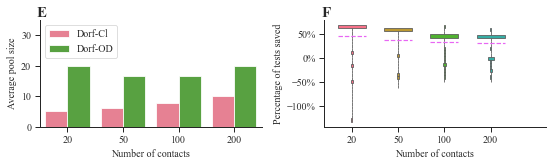

In [11]:
utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.6)
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(2*fig_height*fig_aspect,fig_height))

# Subplot 1
sns.barplot(data=size_df, x="N", y="Average pool size", hue="method", ci=None, 
            palette=[palette[0]]+[palette[2]], hue_order=['binomial', 'negbin'], ax=ax1)
sns.despine(ax=ax1)

# ax1.text(x=0.01, y=1, s=r'A', size=15, transform = ax1.transAxes, horizontalalignment='center', verticalalignment='bottom', weight='bold')
# ax1.text(x=0.01, y=1, s=r'C', size=15, transform = ax1.transAxes, horizontalalignment='center', verticalalignment='bottom', weight='bold')
ax1.text(x=0.01, y=1, s=r'E', size=15, transform = ax1.transAxes, horizontalalignment='center', verticalalignment='bottom', weight='bold')

ax1.legend(labels=['Dorf-Cl', 'Dorf-OD'], loc='upper left')
ax1.set_xlabel("Number of contacts")
ax1.set_ylim([0,35])


# Subplot 2
labels = perc_df['N'].unique()
data_sets = [perc_df[perc_df['N']==N]['Perc'].to_numpy() for N in labels]

hist_range = (np.min(data_sets), np.max(data_sets))
number_of_bins = 30
binned_data_sets=[]
for d in data_sets:
    hist = np.histogram(d, range=hist_range, bins=number_of_bins)[0]
    hist_max = np.max(hist)
    binned_data_sets.append(hist/hist_max)

binned_data_sets = np.array(binned_data_sets)

x_locations = np.linspace(0, len(binned_data_sets)+1, len(binned_data_sets))

i=0
for x_loc, binned_data in zip(x_locations, binned_data_sets):
    non_zero = np.nonzero(binned_data)[0]
    effective_range_ids = non_zero[0], non_zero[-1]
    effective_bins = non_zero[-1] - non_zero[0] + 1
    effective_range = hist_range[0]+non_zero[0]*(hist_range[1]-hist_range[0])/number_of_bins, \
                        hist_range[0]+non_zero[-1]*(hist_range[1]-hist_range[0])/number_of_bins

    bin_edges = np.linspace(effective_range[0], effective_range[1], effective_bins+1)
    centers = 0.5 * (bin_edges + np.roll(bin_edges, 1))[1:]
    
    heights = np.diff(bin_edges)
    lefts = x_loc - 0.5 * binned_data[effective_range_ids[0]:effective_range_ids[1]+1]
    rights = x_loc + 0.5 * binned_data[effective_range_ids[0]:effective_range_ids[1]+1]
    
    ax2.barh(centers, binned_data[effective_range_ids[0]:effective_range_ids[1]+1], height=heights, left=lefts, color=palette[i], edgecolor='#595959')
    
    ax2.hlines(y=means[i], xmin=min(lefts), xmax=max(rights), linestyles='dashed', colors=palette[5])

    i += 1

sns.despine(ax=ax2)

# ax2.text(x=0.01, y=1, s=r'B', size=15, transform = ax2.transAxes, horizontalalignment='center', verticalalignment='bottom', weight='bold')
# ax2.text(x=0.01, y=1, s=r'D', size=15, transform = ax2.transAxes, horizontalalignment='center', verticalalignment='bottom', weight='bold')
ax2.text(x=0.01, y=1, s=r'F', size=15, transform = ax2.transAxes, horizontalalignment='center', verticalalignment='bottom', weight='bold')

ax2.set_xticks(x_locations)
ax2.set_xticklabels(labels)

ax2.set_ylabel(r'Percentage of tests saved', loc='center')
ax2.set_xlabel("Number of contacts")
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
ax2.set_xlim([-1, 7])

fig.tight_layout()
# fig.savefig('figures/fig1.tif', dpi=300)
# fig.savefig('figures/figs2a.tif', dpi=300)
# fig.savefig('figures/figs2b.tif', dpi=300)
fig.savefig('figures/figs2c.tif', dpi=300)